In [5]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import medleydb as mdb
import librosa
import librosa.display
import IPython.display as ipd
import sklearn.metrics as metrics
%matplotlib notebook

HOME_PATH = os.path.expanduser("~")
DATA_PATH = os.path.join(HOME_PATH, 'data', 'preprocessed')
UNSEEN_PATH = os.path.join(HOME_PATH, 'data', 'es_data',)

OPENMIC_TO_MEDLEY = {"drums" : ["drum set"],
                     "bass" : ["electric bass", "double bass"],
                     "guitar" : ["distorted electric guitar", "clean electric guitar", "acoustic guitar"], 
                     "voice" : ["male singer", "female singer", "male speaker", "female speaker",
                                "male rapper", "female rapper", "beatboxing", "vocalists", "choir",
                                "male screamer", "female screamer"], 
                     "piano" : ["piano", "tack piano", "electric piano"],
                     "synthesizer" : ["synthesizer"],
                     #"organ" : ["pipe organ", "electric organ"],
                     #"accordion" : ["accordion"],
                     #"banjo" : ["banjo"], 
                     "cello" : ["cello", "cello section"], 
                     "clarinet" : ["clarinet", "clarinet section", "bass clarinet"], 
                     "cymbals" : ["cymbal"],
                     "flute" : ["flute", "dizi", "flute", "flute section", "piccolo",
                                "bamboo flute", "panpipes", "recorder"],
                     "mallet_percussion" : ["xylophone", "vibraphone", "glockenspiel", "marimba"],
                     "mandolin" : ["mandolin"],
                     "saxophone": ["alto saxophone", "baritone saxophone", "tenor saxophone", "soprano saxophone"], 
                     "trombone": ["trombone", "trombone section"], 
                     "trumpet" : ["trumpet", "trumpet section"],
                     #"ukulele" : ["ukulele"], 
                     "violin" : ["violin", "violin seciton"]} 

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key : i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}

MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}

NUM_LABELS = len(INSTRUMENTS)

spectrogram_params = {'sample_rate' : 16000,
                      'spectrogram_len' : 8.191,
                      'n_fft' : 1024,
                      'hop_length' : 512,
                      'n_mels' : 128}

def play_medley_audio(track):
    track_id = load_track(track).mix_path
    samples, sample_rate = librosa.load(track_id)
    ipd.display(ipd.Audio(samples, rate=sample_rate, autoplay=True))

def play_audio(track):
    homedir = os.path.expanduser("~")
    path = os.path.join(homedir, "data/es_data", track)
    samples, sample_rate = librosa.load(path)
    ipd.display(ipd.Audio(samples, rate=sample_rate, autoplay=True))
    
def load_track(track_id):
    t_gen = mdb.load_multitracks([track_id])
    return next(t_gen)

def display_spectrogram(s, p):
    librosa.display.specshow(s, x_axis='time',
                 y_axis='mel', sr=p['sample_rate'],
                 hop_length=p['hop_length'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    
def display_chromagram(s):
    chroma = librosa.feature.chroma_stft(y=s, sr=22050)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title('Chromagram')
    plt.tight_layout()
    plt.show()
    
def calculate_conv_output(input_dim, filter_size, stride, padding):
    print((input_dim[0]+(2*padding[0])-filter_size[0])//stride[0] + 1, (input_dim[1]+(2*padding[1])-filter_size[1])//stride[1] + 1)
    
calculate_conv_output([1,256], [1,1], [1,1], [0,0])

def calculate_pool_output(input_dim, pool_size, stride):
    h = (input_dim[0]-pool_size[0])/stride[0] + 1
    w = (input_dim[1]-pool_size[1])/stride[1] + 1
    print(h,w)
    return [h,w]
    
def pooling_helper(input_dim, pools):
    for pool in pools:
        input_dim = calculate_pool_output(input_dim, pool, pool)
        
#pooling_helper([128,256], [[2,1],[4,1],[4,1],[1,1]])
    
def plot_loss(train_score, val_score):
    plt.plot(train_score)
    plt.plot(val_score)
    plt.show()


    
# TODO: import this later
def create_spectrogram(track, spectrogram_params):
    spectrogram_len = spectrogram_params['spectrogram_len']
    n_fft = spectrogram_params['n_fft']
    hop_length = spectrogram_params['hop_length']
    n_mels = spectrogram_params['n_mels']
    sr = spectrogram_params['sample_rate']
    
    y, sr = librosa.load(track, sr=sr)
    assert len(y)//sr > spectrogram_len  
    samples_per_spectrogram = int(sr*spectrogram_len)
    num_spectrograms = len(y)//samples_per_spectrogram 
    # Remove samples that doesn't divide equally with s_p_s
    y = y[:num_spectrograms*samples_per_spectrogram]
    spectrograms = []
    # could optimize by saving spectrograms directly here
    # however imo code is cleaner if saved in helper func
    for i in range(0, len(y), samples_per_spectrogram):
        sound_bite = y[i:i+samples_per_spectrogram]
        S = librosa.feature.melspectrogram(y=sound_bite, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = librosa.power_to_db(S, ref=np.max).astype(np.float32)
        spectrograms.append(S_dB)    
    spectrograms = np.stack(spectrograms, axis=0)
    return spectrograms

1 256


In [6]:
class MedleyDB(Dataset):
    def __init__(self, base_path, input_transform=None, train=True, debug=False):
        self.base_path = base_path
        self.input_path = os.path.join(base_path, "input")
        self.label_path = os.path.join(base_path, "matrix_labels")
        self.inputs = os.listdir(self.input_path)
        self.debug = debug
    def __getitem__(self, idx):
        input_file_name = self.inputs[idx]
        spectrogram = np.load(os.path.join(self.input_path, input_file_name))
        label = np.load(os.path.join(self.label_path, input_file_name))
        if self.debug:
            return input_file_name, spectrogram, label
        else:
            #return spectrogram, label
            return np.expand_dims(spectrogram, axis=0), label
    
    def __len__(self):
        return len(self.inputs)
    
class NonLabeled(Dataset):
    def __init__(self, base_path, input_transform=None, train=True, debug=False):
        self.base_path = base_path
        self.input_path = os.path.join(base_path, "input")
        self.inputs = os.listdir(self.input_path)
        self.inputs.sort()
        self.debug = debug
        
    def __getitem__(self, idx):
        input_file_name = self.inputs[idx]
        spectrogram = np.load(os.path.join(self.input_path, input_file_name))
        if self.debug:
            return input_file_name, np.expand_dims(spectrogram, axis=0)
        else:
            return np.expand_dims(spectrogram, axis=0)
    
    def __len__(self):
        return len(self.inputs)

spec_folder = "%d_%d_%d_%d" % (int(spectrogram_params['spectrogram_len']),
                                spectrogram_params['n_fft'],              
                                spectrogram_params['hop_length'],
                                spectrogram_params['n_mels'])
        
TRAIN_PATH = os.path.join(DATA_PATH, spec_folder, "train")
VAL_PATH = os.path.join(DATA_PATH, spec_folder, "validation")
TEST_PATH = os.path.join(DATA_PATH, spec_folder, "test")

train_data = MedleyDB(TRAIN_PATH)
validation_data = MedleyDB(VAL_PATH)
test_data = MedleyDB(TEST_PATH)

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split

batch_size = 32

train = DataLoader(train_data, batch_size=batch_size, shuffle = True)
validation = DataLoader(validation_data, batch_size=batch_size, shuffle = True) 
test = DataLoader(test_data, batch_size=batch_size, shuffle = True)

In [60]:
# Check that data seems OK 
#
#data_loader = iter(train)
#s, l = next(data_loader)
#s = s.numpy()[0]
#print(s.shape)
#l = l.numpy()[0]
#print(l.shape)
#np.set_printoptions(threshold=sys.maxsize)
#print(len(l[0]))
#display_spectrogram(s[0], spectrogram_params)

In [8]:
# "In order to preserve spatial dimensions,
# stride of 1 and Same zero-padding scheme is used for all
# the convolutional layers. Each Conv2D layer is followed by
# batch-normalization [16] and the Exponential Linear Unit
# (ELU) [7] activation function.""
# 
# Conv Block 1, convolve and downsample
# Pixels: 128x44 -> 64x22
# Channels: 1 -> 64
# Max-Pool 2x2 
#
# Conv Block 2, convolve and downsample
# Pixels: 64x22 -> 32x11
# Channels: 64 -> 128
# Max-Pool 2x2
#
# Conv Block 3, convolve and downsample
# Pixels: 32x12 ->  10x4 
# Channels: 128 -> 256
# Max-Pool 3x3
#
# Conv Block 4, convolve and downsample
# Pixels:  10x4 > 3x1
# Channels: 256 -> 640
# Max-Pool 3x3
#
# Flatten: 3*1*640 = 1920
# FC (1920 -> 128)
# FC (128 -> 18)

# REMEMBER TO USE SIGMOID ON OUTPUTS WHEN TESTING BECAUSE LOSS WILL 
# AUTOMATICALLY SIGMOID THE RESULTS FOR US

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # We only pool on the freq. axis
        self.pool_2x1 = nn.MaxPool2d([2,1])
        self.pool_4x1 = nn.MaxPool2d([4,1])
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                                 out_channels = 64,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(in_channels = 64,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(in_channels = 128,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(in_channels = 256,
                                 out_channels = 512,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv4_bn = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(in_channels = 512,
                         out_channels = 16,
                         kernel_size = 1,
                         stride = 1,
                         padding = 0)

    def forward(self, x):
        #print(x.shape)
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.pool_2x1(self.conv1_bn(self.conv1(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv2_bn(self.conv2(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv3_bn(self.conv3(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv4_bn(self.conv4(x))))
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        #(batch x classes x 1 x time) -> (batch x classes x time)
        x = x.view(x.shape[0], x.shape[1], x.shape[3])
        #print(x.shape)
        return x
   
    # torch.Size([8, 64, 64, 256])
    # torch.Size([8, 128, 16, 256])
    # torch.Size([8, 256, 4, 256])
    # torch.Size([8, 512, 1, 256])
    # torch.Size([8, 16, 1, 256])
    # torch.Size([8, 16, 256])


In [9]:
gpu_available = torch.cuda.is_available()
lr = 0.001
batch_size = batch_size
model = Net()
params = model.parameters()
# Binary Cross-Entropy Loss
if gpu_available:
    model.cuda()
    criterion = nn.BCEWithLogitsLoss().cuda()
    #optimizer = optim.SGD(model.parameters(), lr=lr)    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)    
n_epochs = 15
len_data = len(train.dataset)
num_batches = len_data//batch_size

In [63]:
#torch.cuda.empty_cache()
#for batch_idx, (data, target) in enumerate(train):
#    out = model.forward(data.cuda())
#    break

In [135]:
def train_model():
    validation_loss_min = sys.maxsize
    train_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs+1):
        print("Epoch: {}/{}".format(epoch, n_epochs))
        # keep track of training and validation loss
        train_loss = 0.0
        validation_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train):
            print("Batch: {}/{}".format(batch_idx, num_batches), end="\r")
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.float().cuda(), target.float().cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            #print(data.shape)
            output = model(data)
            #print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss, loss.item is the avarage loss of the batch.
            train_loss += loss.item()*data.size(0)
            ######################    
            # validate the model #
            ######################
        model.eval()
        for data, target in validation:
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            validation_loss += loss.item()*data.size(0)
                
         # calculate average losses
        train_loss = train_loss/len(train.sampler)
        validation_loss = validation_loss/len(validation.sampler)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        plot_loss(train_losses, validation_losses)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, validation_loss))

        # save model if validation loss has decreased
        if validation_loss <= validation_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            validation_loss_min,
            validation_loss))
            torch.save(model.state_dict(), 'matrix_label_model.pt')
            validation_loss_min = validation_loss
            
    torch.save(model.state_dict(), 'overfit_matrix_label_model.pt')

In [119]:
train_model()

Epoch: 1/15
Epoch: 1 	Training Loss: 0.336586 	Validation Loss: 0.298232
Validation loss decreased (9223372036854775808.000000 --> 0.298232).  Saving model ...
Epoch: 2/15
Epoch: 2 	Training Loss: 0.256025 	Validation Loss: 0.284466
Validation loss decreased (0.298232 --> 0.284466).  Saving model ...
Epoch: 3/15
Epoch: 3 	Training Loss: 0.231719 	Validation Loss: 0.289287
Epoch: 4/15
Epoch: 4 	Training Loss: 0.220319 	Validation Loss: 0.276486
Validation loss decreased (0.284466 --> 0.276486).  Saving model ...
Epoch: 5/15
Epoch: 5 	Training Loss: 0.204597 	Validation Loss: 0.282794
Epoch: 6/15
Epoch: 6 	Training Loss: 0.195866 	Validation Loss: 0.272377
Validation loss decreased (0.276486 --> 0.272377).  Saving model ...
Epoch: 7/15
Epoch: 7 	Training Loss: 0.186761 	Validation Loss: 0.307465
Epoch: 8/15
Epoch: 8 	Training Loss: 0.180193 	Validation Loss: 0.294125
Epoch: 9/15
Epoch: 9 	Training Loss: 0.174610 	Validation Loss: 0.290962
Epoch: 10/15
Epoch: 10 	Training Loss: 0.167229 	

In [10]:
model.load_state_dict(torch.load('matrix_label_model.pt'))

<All keys matched successfully>

SGD 50 epochs Relu: Epoch: 50 	Training Loss: 0.310960 	Validation Loss: 0.312199
Adam 50 epochs Relu: Epoch: 50 	Training Loss: 0.001489 	Validation Loss: 0.074400
                     Best: Validation loss decreased (0.074246 --> 0.073360).  Saving model ...
     
Without negatives: 
Epoch: 9 	Training Loss: 0.071606 	Validation Loss: 0.294554
Validation loss decreased (0.306978 --> 0.294554).  Saving model ...
Epoch: 50 	Training Loss: 0.005509 	Validation Loss: 0.522374



In [11]:
# REMEMBER TO MANUALLY SIGMOID THE OUTPUTS SINCE THE LOSS DOES THAT FOR US
# TODO: Don't hard-code number of classes
#def test_model(model, num_batches=num_batches):
#    model.eval()
#    # track test loss
#    test_loss = 0.0 
#    # iterate over test data
#    count = 0
#    
#    labels_total = torch.zeros(NUM_LABELS).cuda()
#    correct_pred = torch.zeros(NUM_LABELS).cuda()
#    
#    for data, target in test:
#        print(len(test))
#        # move tensors to GPU if CUDA is available
#        if gpu_available:
#            data, target = data.cuda(), target.cuda()
#            
#        if count == 0: 
#            scores = torch.tensor([num_batches*len(test)])
#            predictions = torch.tensor([])
#            targets = torch.tensor([])
#        # forward pass: compute predicted outputs by passing inputs to the model
#        output = model(data)
#        # calculate the batch loss
#        loss = criterion(output, target)
#        # update test loss 
#        test_loss += loss.item()*data.size(0)
#        # convert output probabilities to predicted class
#        
#        # Convert to score and use threshhold 0.5
#        output = sigmoid(output)
#        
#        pred = (output > 0.5).float()
#        # List concat, to be returned and used by scikit for metrics
#       #for i in range(output.shape[0]):
#       #    for j in range(output.shape[2]):
#       #        scores = scores + list(output.data[i, :, j].cpu().numpy())
#       #        predictions = predictions + list(pred[i, :, j].cpu().numpy())
#       #        targets = targets + list(target.data[i, :, j].cpu().numpy())
#       
#        # compare predictions to true label
#        correct = pred.eq(target.data.view_as(pred))
#        true_positives = np.logical_and(pred.cpu().numpy(), correct.cpu().numpy())
#        
#        # Go through the batch, aggregate true positives
#        for i in range(target.shape[0]):
#            # Elementwise addition
#            labels_total = np.add(labels_total, np.sum(target.data[i].cpu().numpy(), axis=1))
#            correct_pred = np.add(correct_pred, np.sum(true_positives[i], axis=1))
#            
#        count += 1
#
#    # average test loss
#    test_loss = test_loss/len(test)
#    print('Test Loss: {:.6f}\n'.format(test_loss))
#    np.set_printoptions(suppress=True)
#    print(labels_total)
#    print(correct_pred)
#    return np.array(scores), np.array(predictions), np.array(targets)
#
#scores, predictions, targets = test_model(model, num_batches)

In [153]:
# REMEMBER TO MANUALLY SIGMOID THE OUTPUTS SINCE THE LOSS DOES THAT FOR US
# TODO: Don't hard-code number of classes
def test_model(model, num_batches=num_batches):
    model.eval()
    # track test loss
    test_loss = 0.0 
    # iterate over test data
    
    labels_total = np.zeros(NUM_LABELS)
    correct_pred = np.zeros(NUM_LABELS)
    
    labels_total_test = torch.zeros(NUM_LABELS).cuda()
    correct_pred_test = torch.zeros(NUM_LABELS).cuda()
    
    scores = torch.zeros([0, 16]).cuda()
    predictions = torch.zeros([0,16]).cuda()
    targets = torch.zeros([0,16]).cuda()
    
    for idx, (data, target) in enumerate(test):
        if gpu_available:
            data, target = data.float().cuda(), target.float().cuda()
            
        #if idx == 0: 
        #    # init here since we get data dims
        #    scores = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])
        #    predictions = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])
        #    targets = torch.zeros([len(test.dataset)*target.shape[2], target.shape[1]])

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        
        # Convert to score and use threshhold 0.5
        output = sigmoid(output)
        
        pred = (output > 0.5).float()
        
        scores = torch.cat([scores, output.data.permute(0,2,1).reshape(-1, 16)], dim=0)
        predictions = torch.cat([predictions, pred.data.permute(0,2,1).reshape(-1, 16)], dim=0)
        targets = torch.cat([targets, target.data.permute(0,2,1).reshape(-1, 16)], dim=0)
       
        # compare predictions to true label
        correct = pred.eq(target.data.view_as(pred))
        #true_positives = np.logical_and(pred.cpu().numpy(), correct.cpu().numpy())
        true_positives = pred * correct
        
        labels_total_test = labels_total_test + torch.sum(target.permute(0,2,1).reshape(-1, 16), axis=0)
        correct_pred_test = correct_pred_test + torch.sum(true_positives.permute(0,2,1).reshape(-1, 16), axis=0)

        # Go through the batch, aggregate true positives
        #for i in range(target.shape[0]):
            # Elementwise addition
            
    # average test loss
    test_loss = test_loss/len(test)
    print(labels_total_test)
    print(correct_pred_test)
    print('Test Loss: {:.6f}\n'.format(test_loss))
    np.set_printoptions(suppress=True)
    return scores.cpu().numpy(), predictions.cpu().numpy(), targets.cpu().numpy()

#scores, predictions, targets = test_model(model, num_batches)
scores, predictions, targets = test_model(model, num_batches)

tensor([ 98293., 115541., 124584.,  60653.,  74214.,  39586.,  15183.,   2289.,
           501.,   6664.,   1604.,  23396.,   2170.,    508.,   2715.,  22055.],
       device='cuda:0')
tensor([7.5141e+04, 1.0266e+05, 6.3808e+04, 3.6863e+04, 3.5114e+04, 5.2180e+03,
        7.1680e+03, 0.0000e+00, 0.0000e+00, 8.1000e+01, 0.0000e+00, 3.9950e+03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0569e+04], device='cuda:0')
Test Loss: 8.056275



tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]],

        [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
         [50, 51, 52, 53, 54, 55, 56, 57, 58, 59]]])
tensor([[ 0, 10, 20],
        [ 1, 11, 21],
        [ 2, 12, 22],
        [ 3, 13, 23],
        [ 4, 14, 24],
        [ 5, 15, 25],
        [ 6, 16, 26],
        [ 7, 17, 27],
        [ 8, 18, 28],
        [ 9, 19, 29],
        [30, 40, 50],
        [31, 41, 51],
        [32, 42, 52],
        [33, 43, 53],
        [34, 44, 54],
        [35, 45, 55],
        [36, 46, 56],
        [37, 47, 57],
        [38, 48, 58],
        [39, 49, 59]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],

In [146]:
def calculate_metrics(scores, predictions, targets):
    f1_macro = metrics.f1_score(targets, predictions, average='macro')
    f1_micro = metrics.f1_score(targets, predictions, average='micro')
    lrap = metrics.label_ranking_average_precision_score(targets, scores)
    auc_roc_micro = metrics.roc_auc_score(targets, scores, average='micro')
    auc_roc_macro = metrics.roc_auc_score(targets, scores, average='macro')
    precision, recall, f_score, support = metrics.precision_recall_fscore_support(targets, predictions, average=None)
    #s = np.array([[0.5, 0.7, 0.3], [0.2, 0.5, 0.8], [0.2, 0.5, 0.8]])
    #t = np.array([[1,1,1], [1,0,1], [0,1,0]])
    #print(scores.shape)
    #print(targets.shape)
    print("F1-Macro:", f1_macro)
    print("F1-Micro:", f1_micro)
    print("lrap:", lrap)
    print("AUC-ROC-Macro:", auc_roc_macro)
    print("AUC-ROC-Micro:", auc_roc_micro)
    return {'f1_micro' : f1_micro,
            'f1_macro' : f1_macro, 
            'lrap' : lrap, 
            'auc_roc_macro' : auc_roc_macro,
            'auc_roc_micro' : auc_roc_micro, 
            'precision' : precision,
            'recall' : recall,
            'f_score' : f_score,
            'support' : support}

In [147]:
accuracies = calculate_metrics(scores, predictions, targets)
precision = accuracies['precision']
recall = accuracies['recall']

(206848, 16) (206848, 16) (206848, 16)
F1-Macro: 0.3166896847423443
F1-Micro: 0.6477730021680422
lrap: 0.7835182741420872
AUC-ROC-Macro: 0.7688768456377902
AUC-ROC-Micro: 0.9218896804368768


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [148]:
print(precision)
print(recall)

[0.82223754 0.73646414 0.79769971 0.64385021 0.72212397 0.37707761
 0.83290727 0.         0.         0.13170732 0.         0.72281527
 0.         0.         0.         0.65112124]
[0.76445932 0.88847249 0.5121685  0.60776878 0.47314523 0.13181428
 0.47210696 0.         0.         0.01215486 0.         0.17075568
 0.         0.         0.         0.47921106]


In [ ]:
#np.set_printoptions(threshold=sys.maxsize)
#print(predictions[0:50,:])
#print(targets[0:50, :])
#
#target = torch.arange(0, 60).reshape((2, 3, 10))   
#
#print(target)
#print(target.permute((0, 2, 1)).reshape(-1,3))
#print(target.reshape(-1, 10))

torch.Size([16, 5888])


<IPython.core.display.Javascript object>


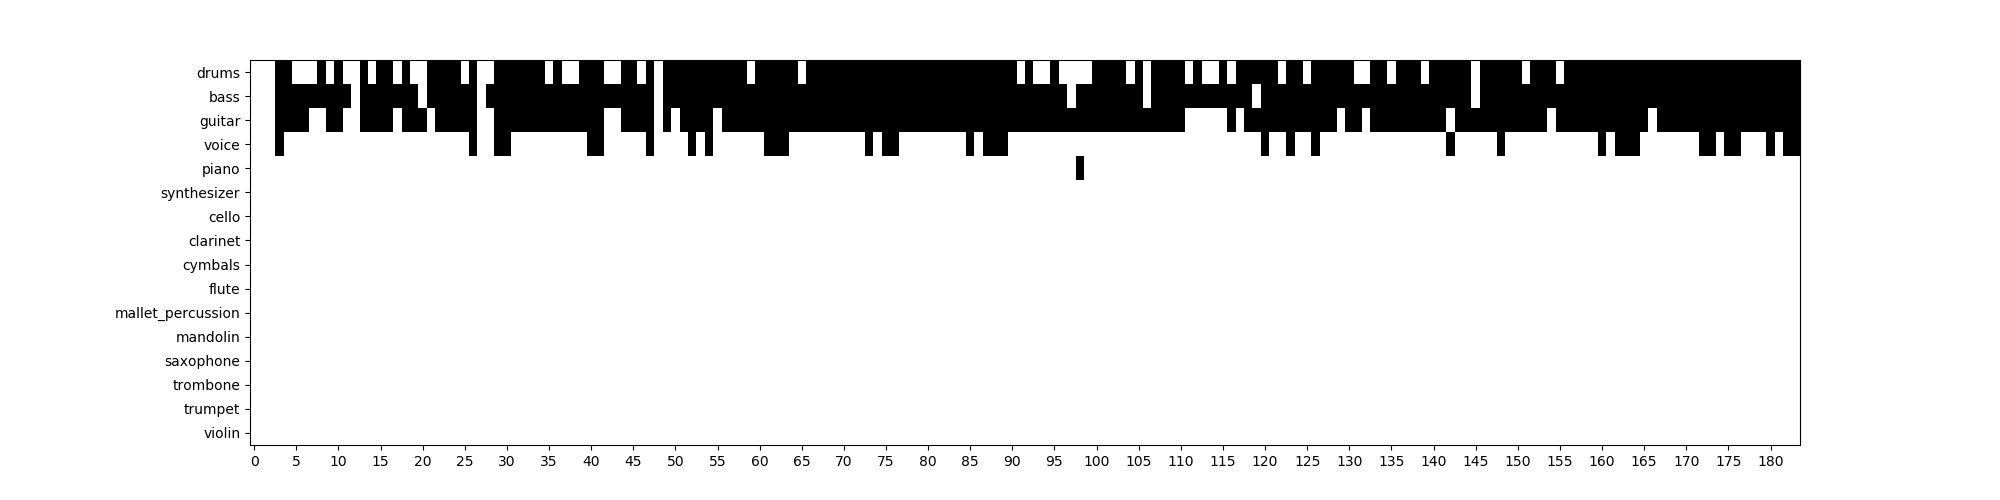

In [48]:
def visualize_song_predictions(predictions):
    cmap = mpl.colors.ListedColormap(['white','black'])
    bounds = [0,0,1,1]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    instrument_activations = np.transpose(predictions)
    
    fig, ax = plt.subplots(figsize=(20,5))
    #fig.set_size_inches(30,20)
    plt.yticks(np.arange(0,17, step=1))
    plt.xticks(np.arange(0,len(predictions), step=5))
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels = [REV_INSTRUMENT_INDEX[x] for x in range(predictions.shape[1])]
    ax.set_yticklabels(labels)
    #pyplot.yticks([REV_INSTRUMENT_INDEX[x] for x in range(18)])
    img = plt.imshow(instrument_activations,
                        interpolation='nearest',
                        cmap=cmap,
                        aspect='auto')

def test_model_on_unseen(model, path):
    model.eval()
    test_data_path = os.path.join(HOME_PATH, path)
    inputs = create_spectrogram(path, spectrogram_params)
    predictions = torch.zeros([16, 0]).cuda()
    for s in inputs:
        s = np.expand_dims(s, axis=0)
        s = np.expand_dims(s, axis=0)
        s = torch.from_numpy(s).cuda()
        output = model(s)
        predictions = torch.cat([predictions, (sigmoid(output) > 0.5)[0].float()], axis=1)
    
    # https://stackoverflow.com/questions/15956309/averaging-over-every-n-elements-of-a-numpy-array
    print(predictions.shape)
    predictions = predictions.reshape(16, -1, 32)
    predictions = torch.mean(predictions, axis=2)
    predictions = torch.ge(predictions, 1.0).float()
    predictions = torch.t(predictions)
    predictions = predictions.cpu().numpy()
    
    visualize_song_predictions(predictions)
    split_path = path.split("/")
    track_name = split_path[-1]
    #play_audio("%s.wav" % track_name)
    #labels = [item.get_text() for item in ax.get_yticklabels()]
    #labels[0] = 'Testing'
    #ax.set_yticklabels(labels)
    #return predictions
    #np.set_printoptions(threshold=sys.maxsize)
    #print(np.transpose(predictions))
    #print(predictions)
    #f, s  = next(test_inputs_loader)
    #s = s.numpy()[0][0]
    #print(s.shape)
    #display_spectrogram(s)
    return predictions
predictions = test_model_on_unseen(model, os.path.join(UNSEEN_PATH, 'ES_Lifes_Passing_Me_By.wav'))

In [46]:
print(REV_INSTRUMENT_INDEX)

{0: 'drums', 1: 'bass', 2: 'guitar', 3: 'voice', 4: 'piano', 5: 'synthesizer', 6: 'cello', 7: 'clarinet', 8: 'cymbals', 9: 'flute', 10: 'mallet_percussion', 11: 'mandolin', 12: 'saxophone', 13: 'trombone', 14: 'trumpet', 15: 'violin'}
